In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
applicative = pd.read_csv('../../../../../../applicative.csv')
configuration = pd.read_csv('../../../../../../configuration.csv')

In [3]:
data = pd.merge(applicative, configuration, left_on='platformId', right_on='platformId', suffixes=('', '_y'))

In [4]:
def prefix_to_numeric(value):

    unit = value[-1]

    units = {
        'k': 10**3,
        'm': 10**6,
        'g': 10**9
    }

    return int(value[:-1]) * units[unit]

def time_to_numeric_ms(time):
    
    if time[-2:] == 'ms':
        return int(time[:-2])
    
    if time[-1] == 's':
        return int(time[:-1]) * 10**3
    
    raise ValueError

In [5]:
parameters = [
    'spark.executor.memory',
    'spark.shuffle.file.buffer',
    'spark.reducer.maxSizeInFlight'
]

for parameter in parameters:
    
    data[parameter] = data[parameter].map(prefix_to_numeric)

data['spark.locality.wait'] = data['spark.locality.wait'].map(time_to_numeric_ms)

In [6]:
def select_workloads(data, datasets, algorithms):
    
    datasets = np.asarray(datasets)
    algorithms = np.asarray(algorithms)
    
    return data[np.isin(data['dataset'], datasets) & np.isin(data['algorithm'], algorithms)]

In [7]:
def select_parameter_variations(data, parameter):
    
    default = data[data['platformId'] == 0][parameter].values[0]
    selection = data[(data[parameter] != default) | (data['platformId'] == 0)].copy()
    
    return selection

In [8]:
def rename(data, mapping):
    
    return data.map(mapping).fillna(data)

def rename_workloads(data):
    
    algorithms = {
        'BisectingKMeans': 'BKM',
        'KMeans': 'KM',
        'Tree': 'DT',
        'Logistic': 'BLR',
        'Linear': 'LR',
        'GBT': 'GBT',
        'RFR': 'RFR',
        'GMM': 'GMM',
        'MLP': 'MLP'
    }
    
    datasets = {
        'drivface': 'DDF',
        'drift': 'DGS',
        'geomagnetic': 'DSS',
        'drugs': 'DDR',
        'higgs': 'DHG'
    }
    
    data['algorithm'] = rename(data['algorithm'], algorithms)
    data['dataset'] = rename(data['dataset'], datasets)
    
    return data

In [9]:
def plot_workloads_parameter(data, parameter, target, **kwargs):
    
    data = select_parameter_variations(data, parameter)

    lm = sns.lmplot(x=parameter, y=target, data=data, col='dataset', row='algorithm', sharex=False, sharey=False, truncate=True)
    
    lm.set(ylim=(0, None))

In [10]:
data = rename_workloads(data)

In [11]:
def plot_workloads_parameter_bis(data, parameter, target, legend=True, yscale=None, yzero=True):
    
    legends = []
    
    for dataset, algorithm in data[['dataset', 'algorithm']].drop_duplicates().values:
        
        workload = select_workloads(data, dataset, algorithm)
        
        if len(workload):
            
            selection = select_parameter_variations(workload, parameter)
            
            sns.lineplot(x=parameter, y=target, data=selection)
            
            legends.append(dataset + '-' + algorithm)
    
    if yzero:
        plt.ylim((0, None))
    
    if yscale is not None:
        plt.yscale(yscale)
    
    if legend:
        plt.legend(legends)

In [30]:
selection = select_workloads(data, ['DHG'], ['GBT'])

(0, 101619.71667469775)

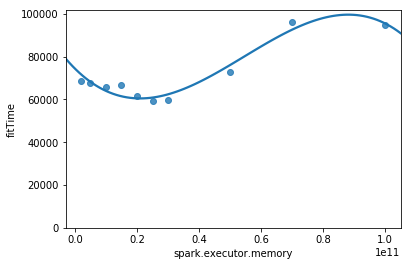

In [53]:
s=select_parameter_variations(selection, 'spark.executor.memory')[['spark.executor.memory', 'fitTime']]
sns.regplot(x='spark.executor.memory', y='fitTime', data=s, order=3, ci=None)
plt.ylim((0, None))

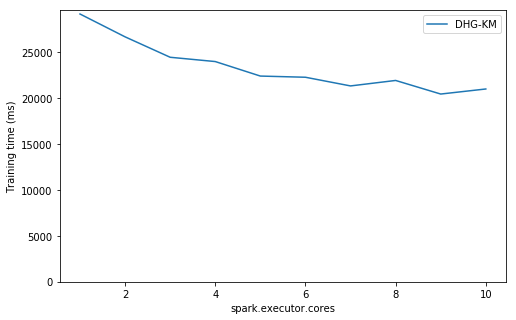

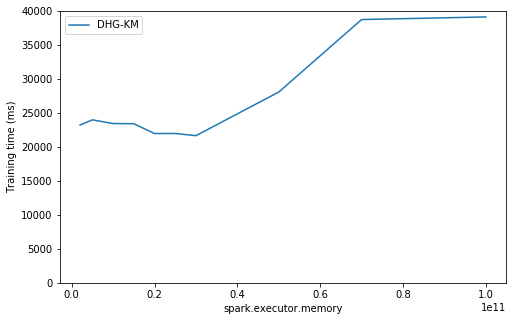

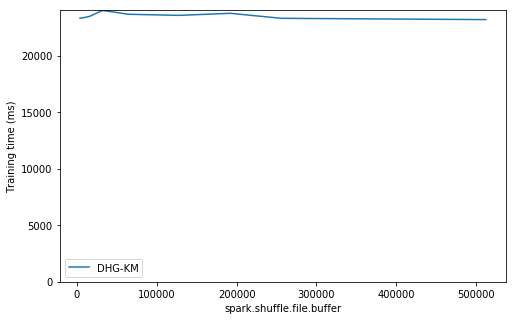

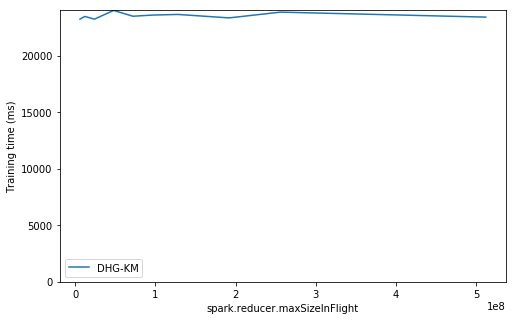

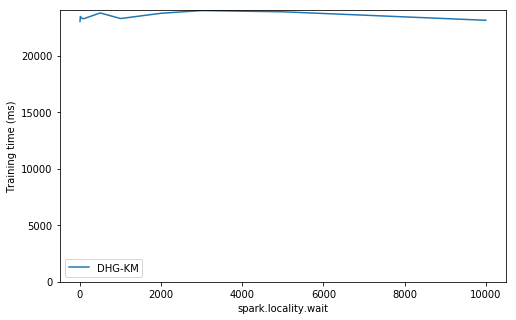

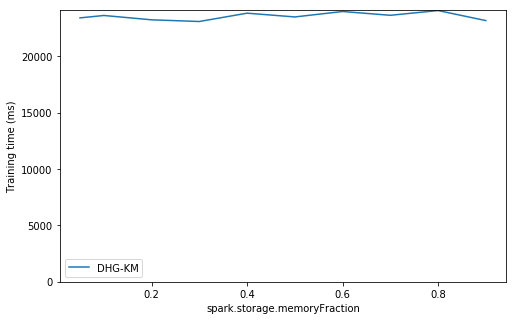

In [29]:
parameters = [
    'spark.executor.cores',
    'spark.executor.memory',
    'spark.shuffle.file.buffer',
    'spark.reducer.maxSizeInFlight',
    'spark.locality.wait',
    'spark.storage.memoryFraction'
]

for parameter in parameters:

    plt.figure(figsize=(8,5))
    plot_workloads_parameter_bis(selection, parameter, 'fitTime', legend=True, yzero=True)
    plt.ylabel('Training time (ms)')
    plt.show()

spark.executor.cores


/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


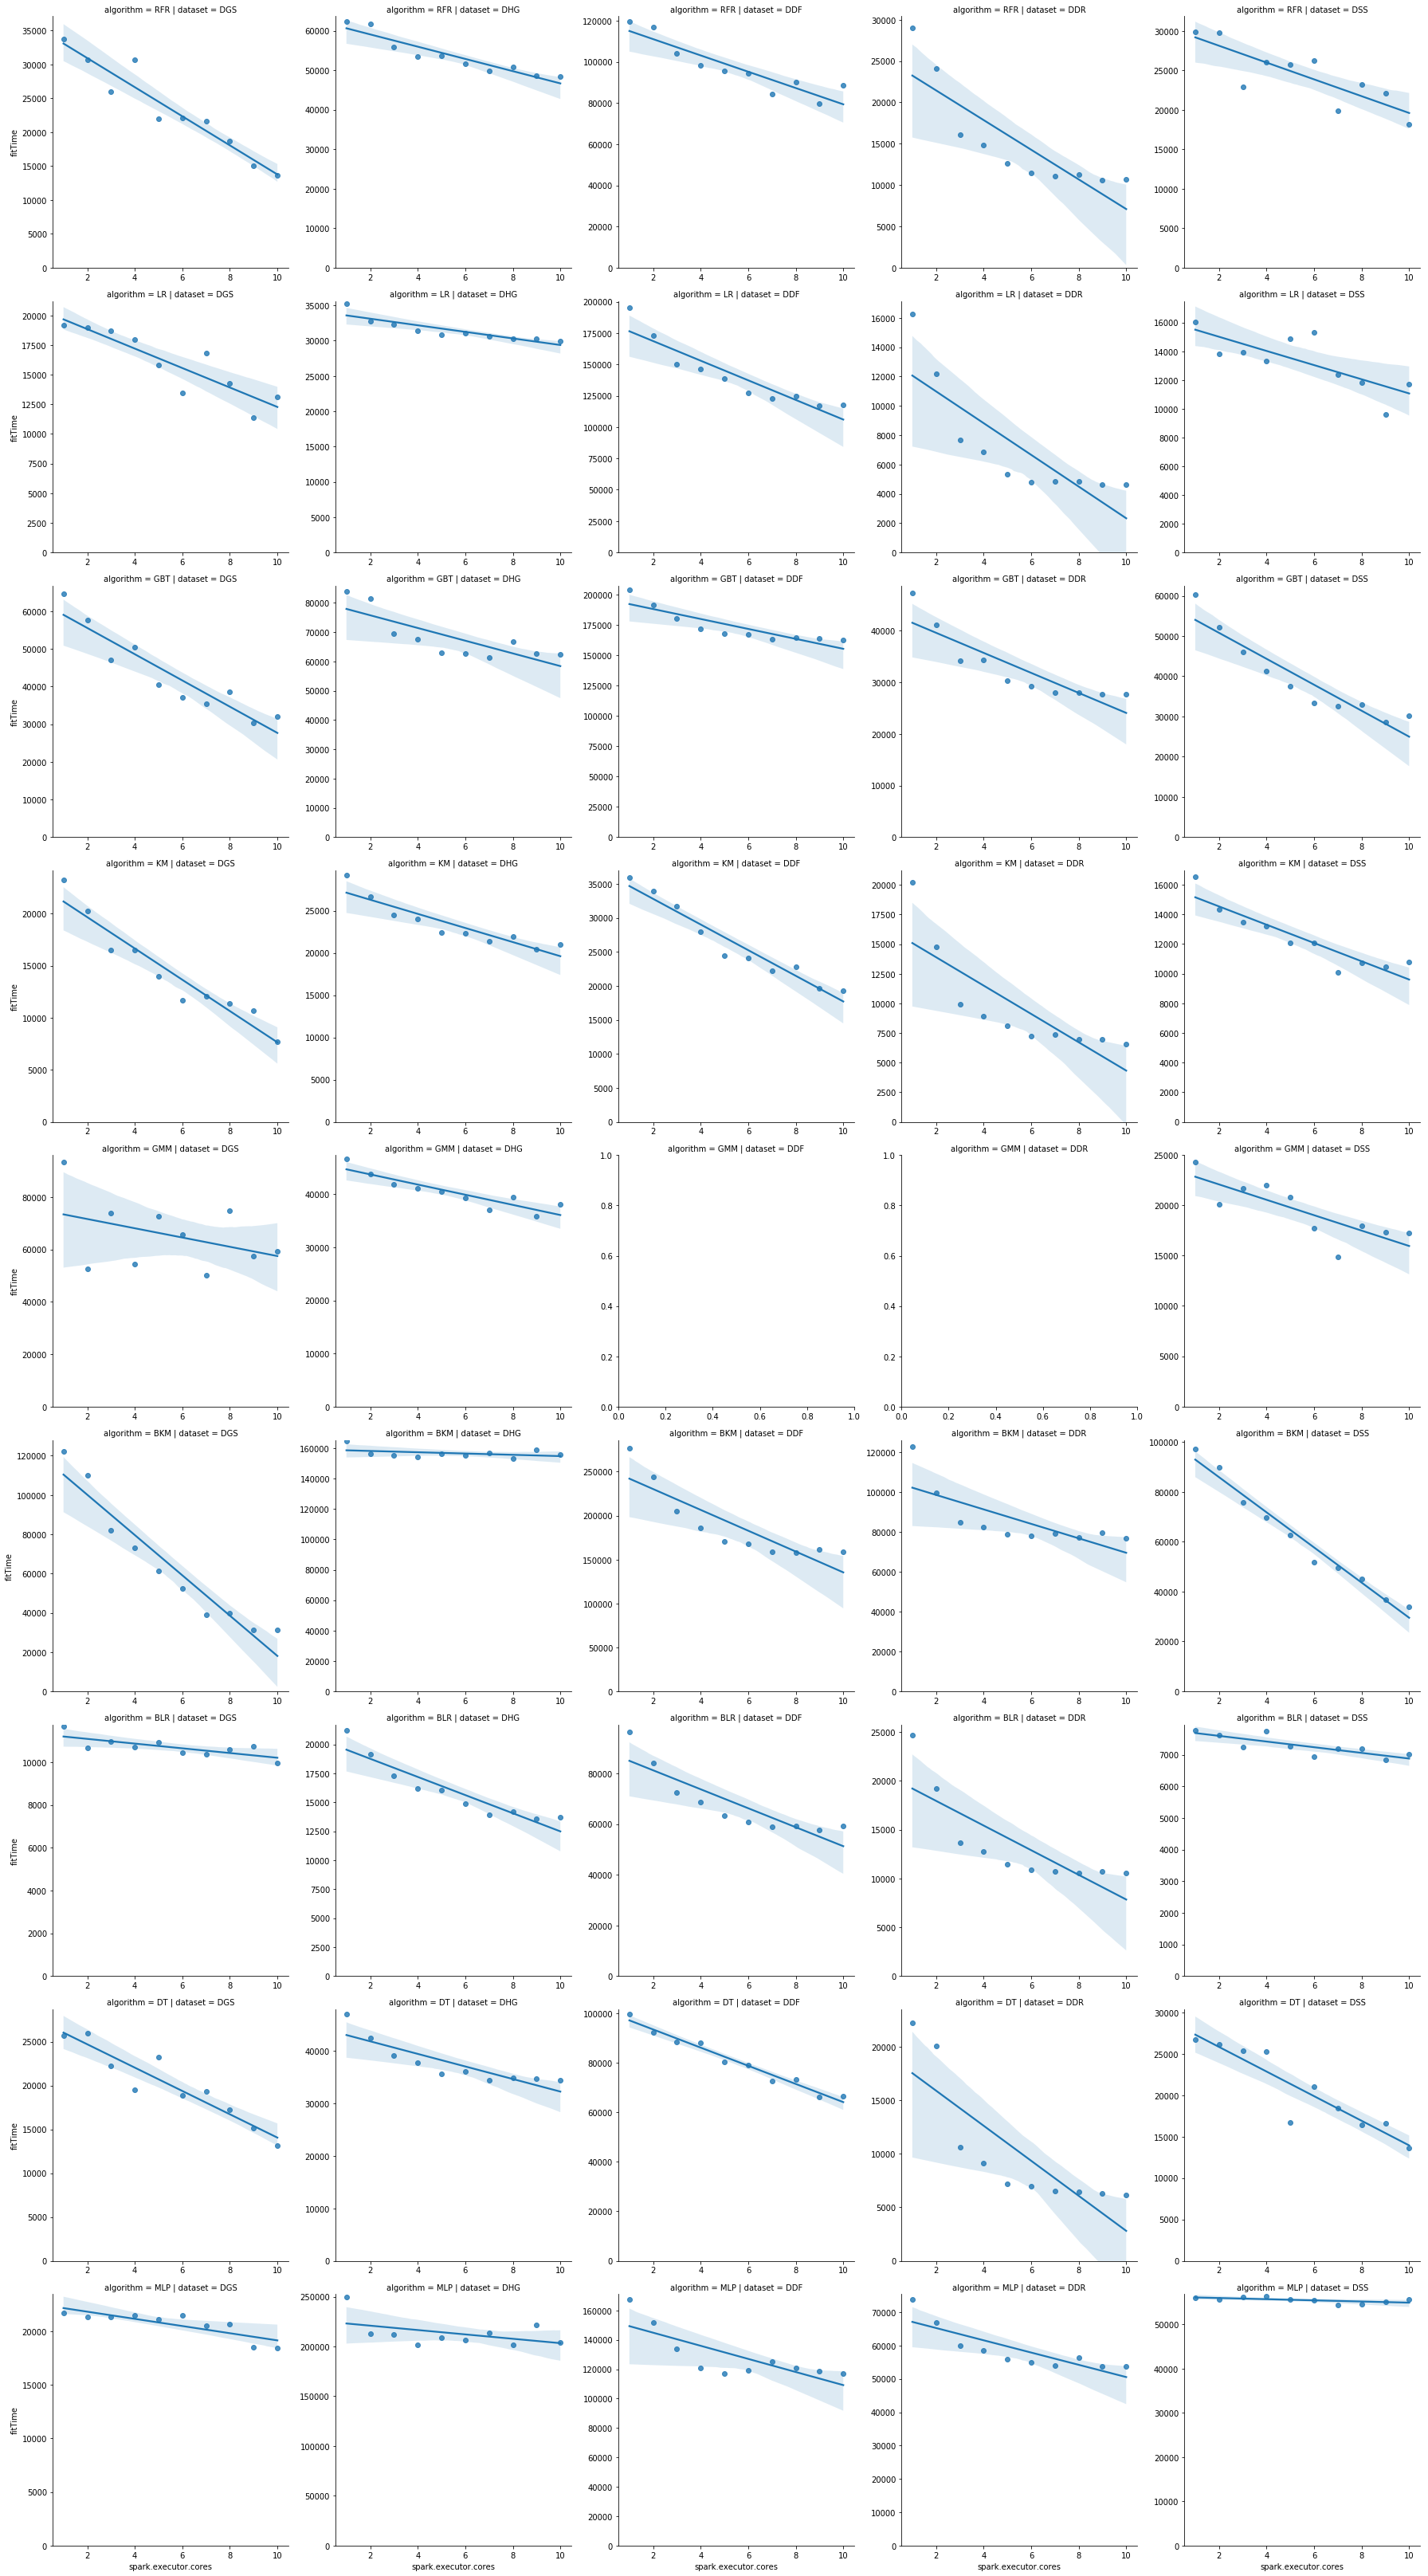

spark.executor.memory


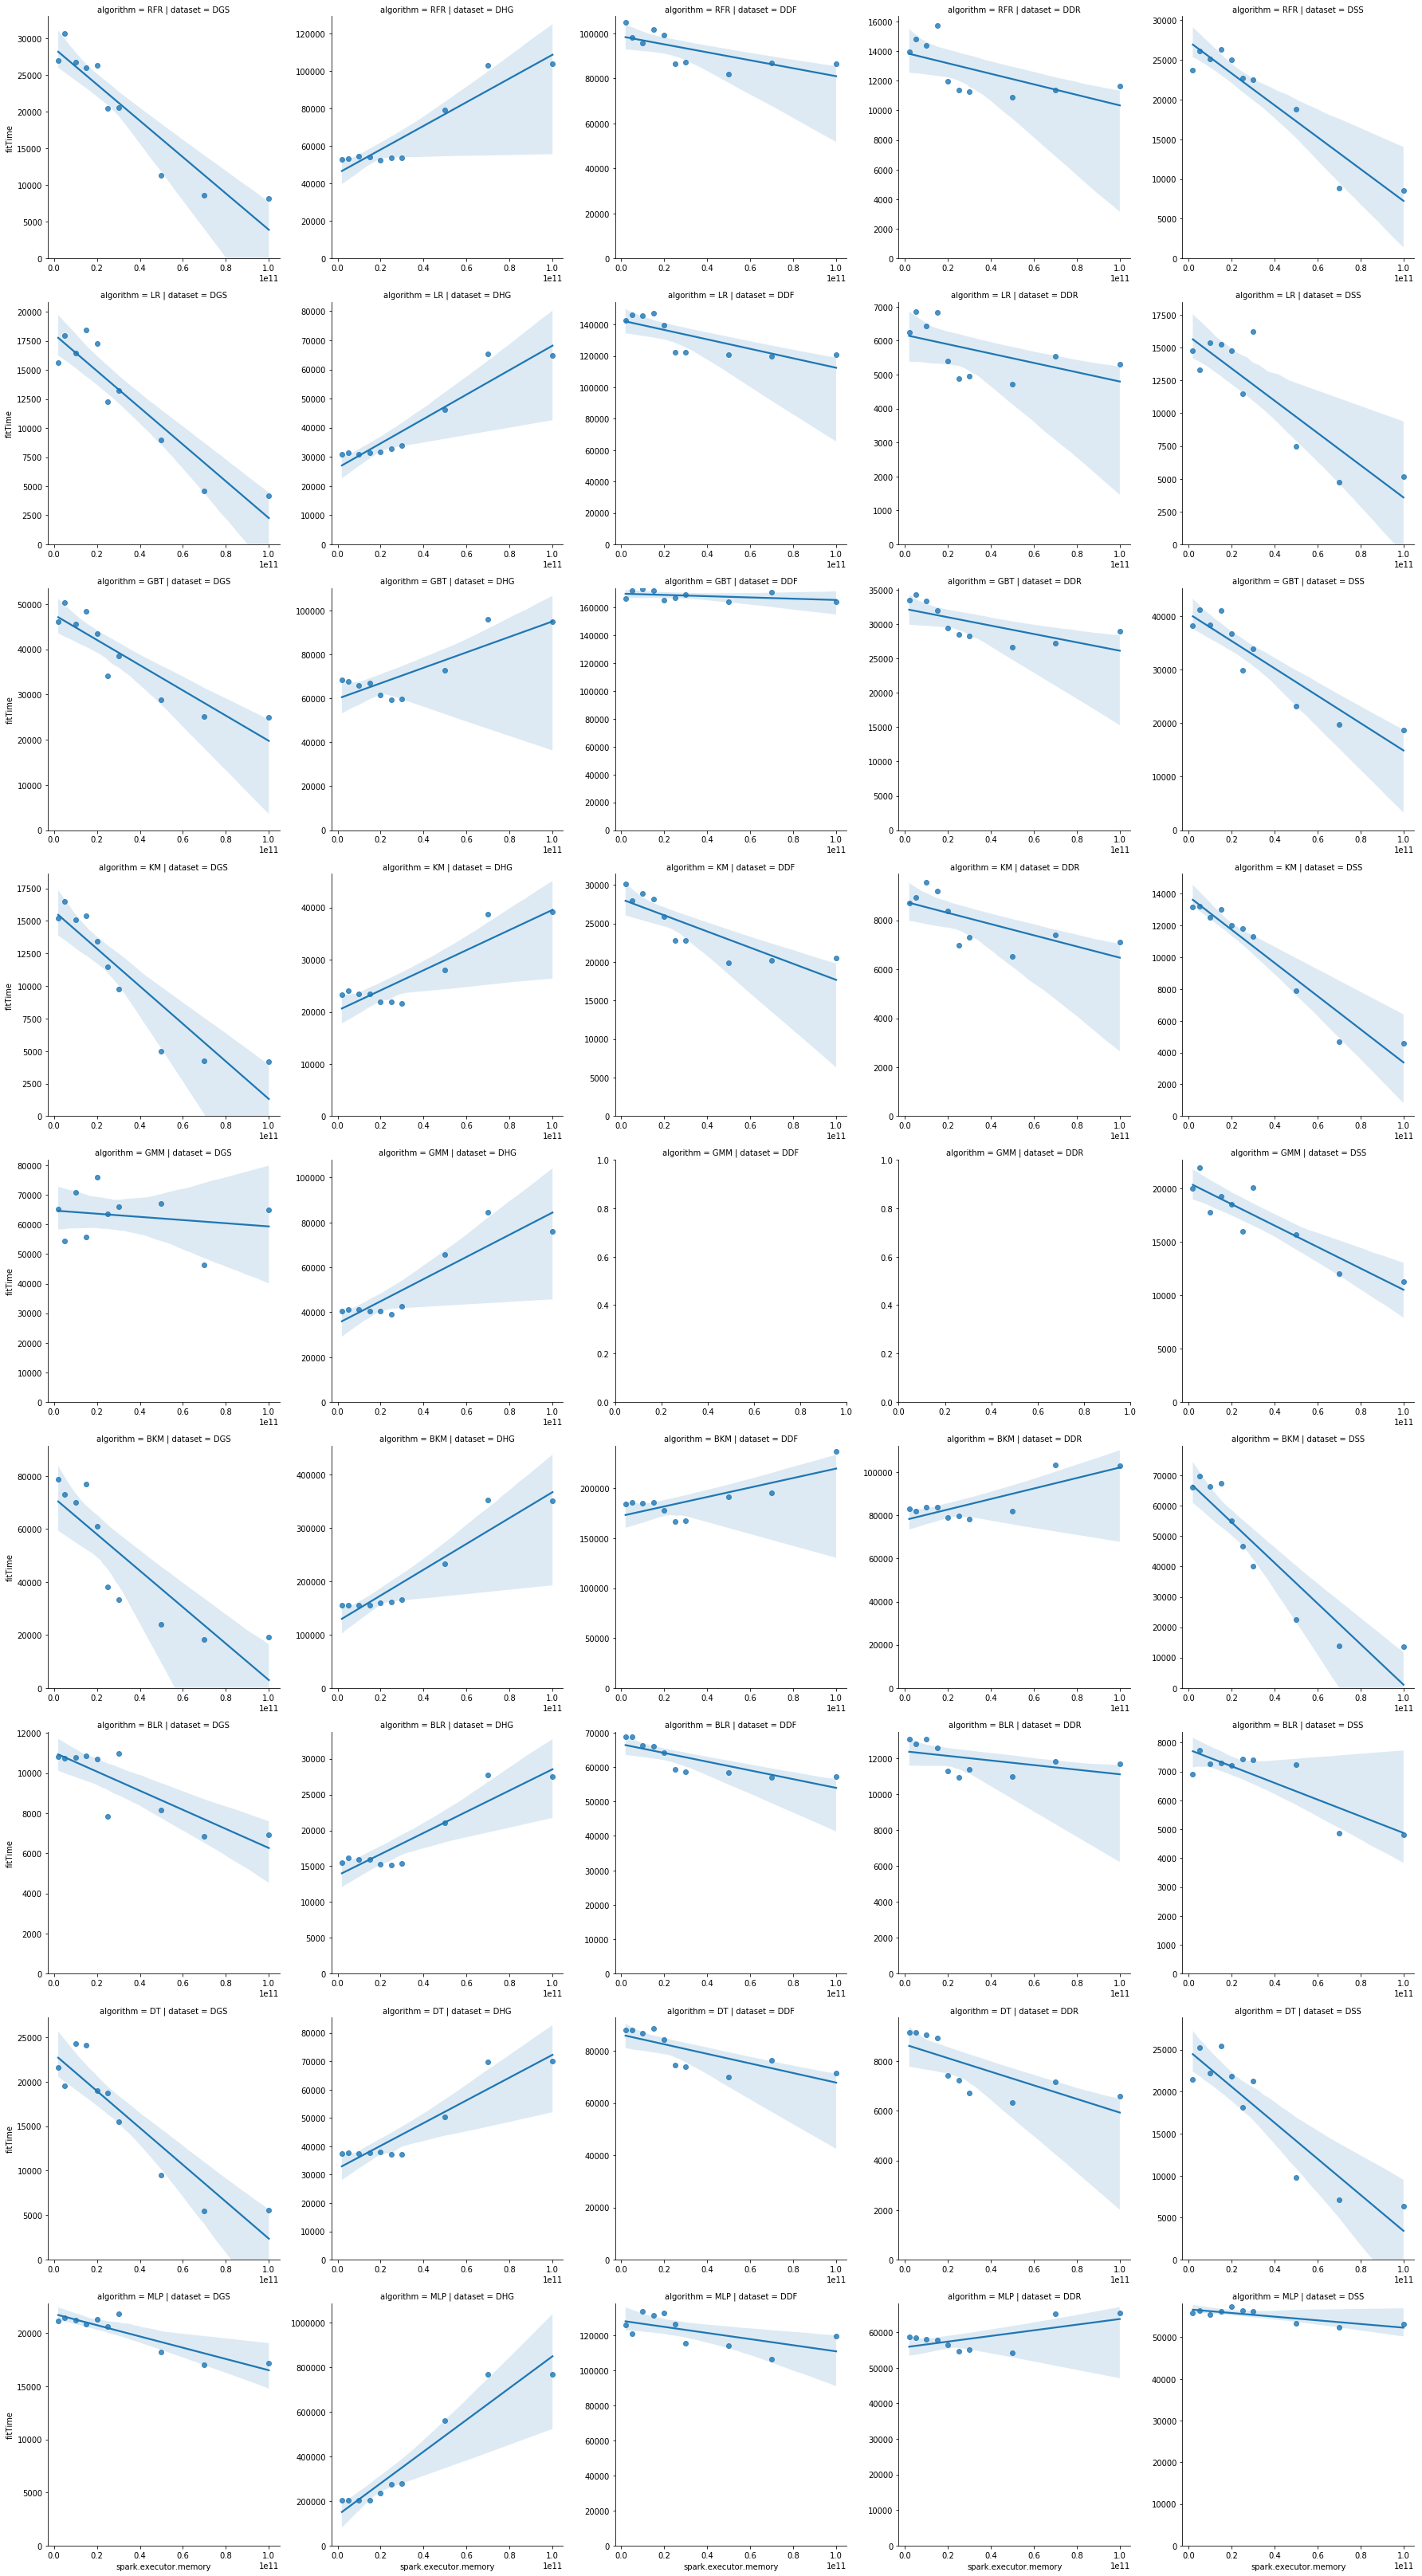

spark.shuffle.file.buffer


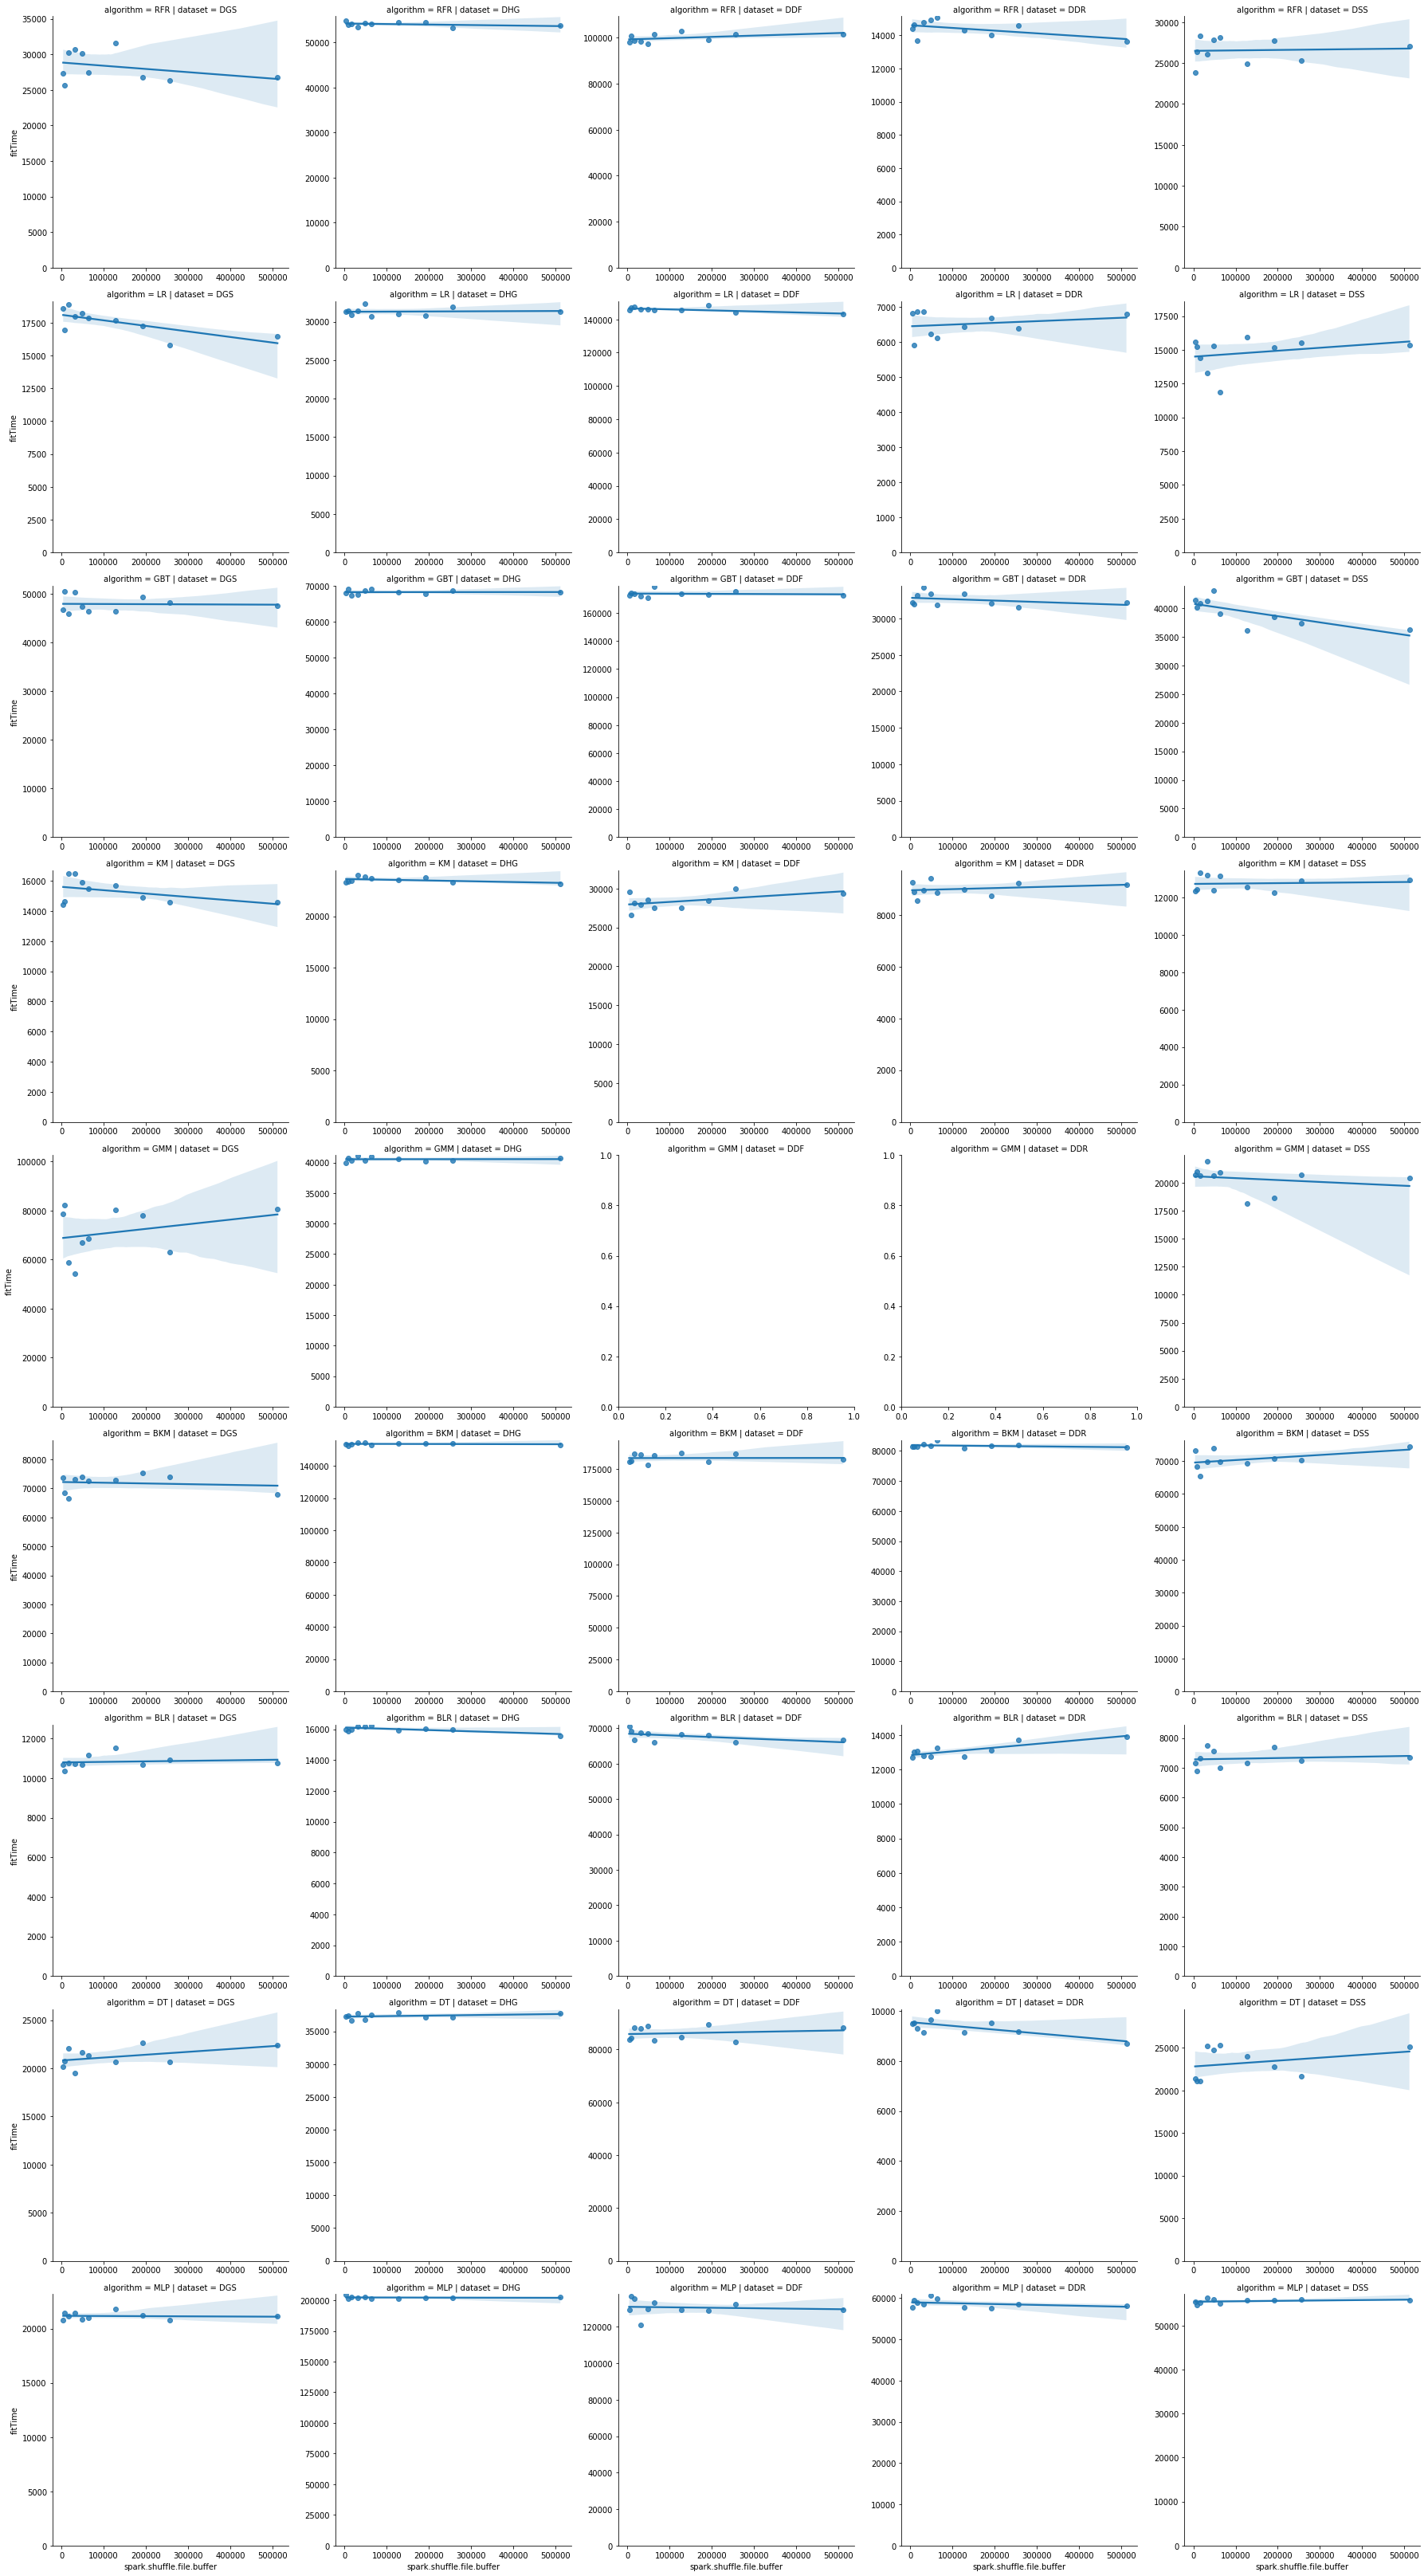

spark.reducer.maxSizeInFlight


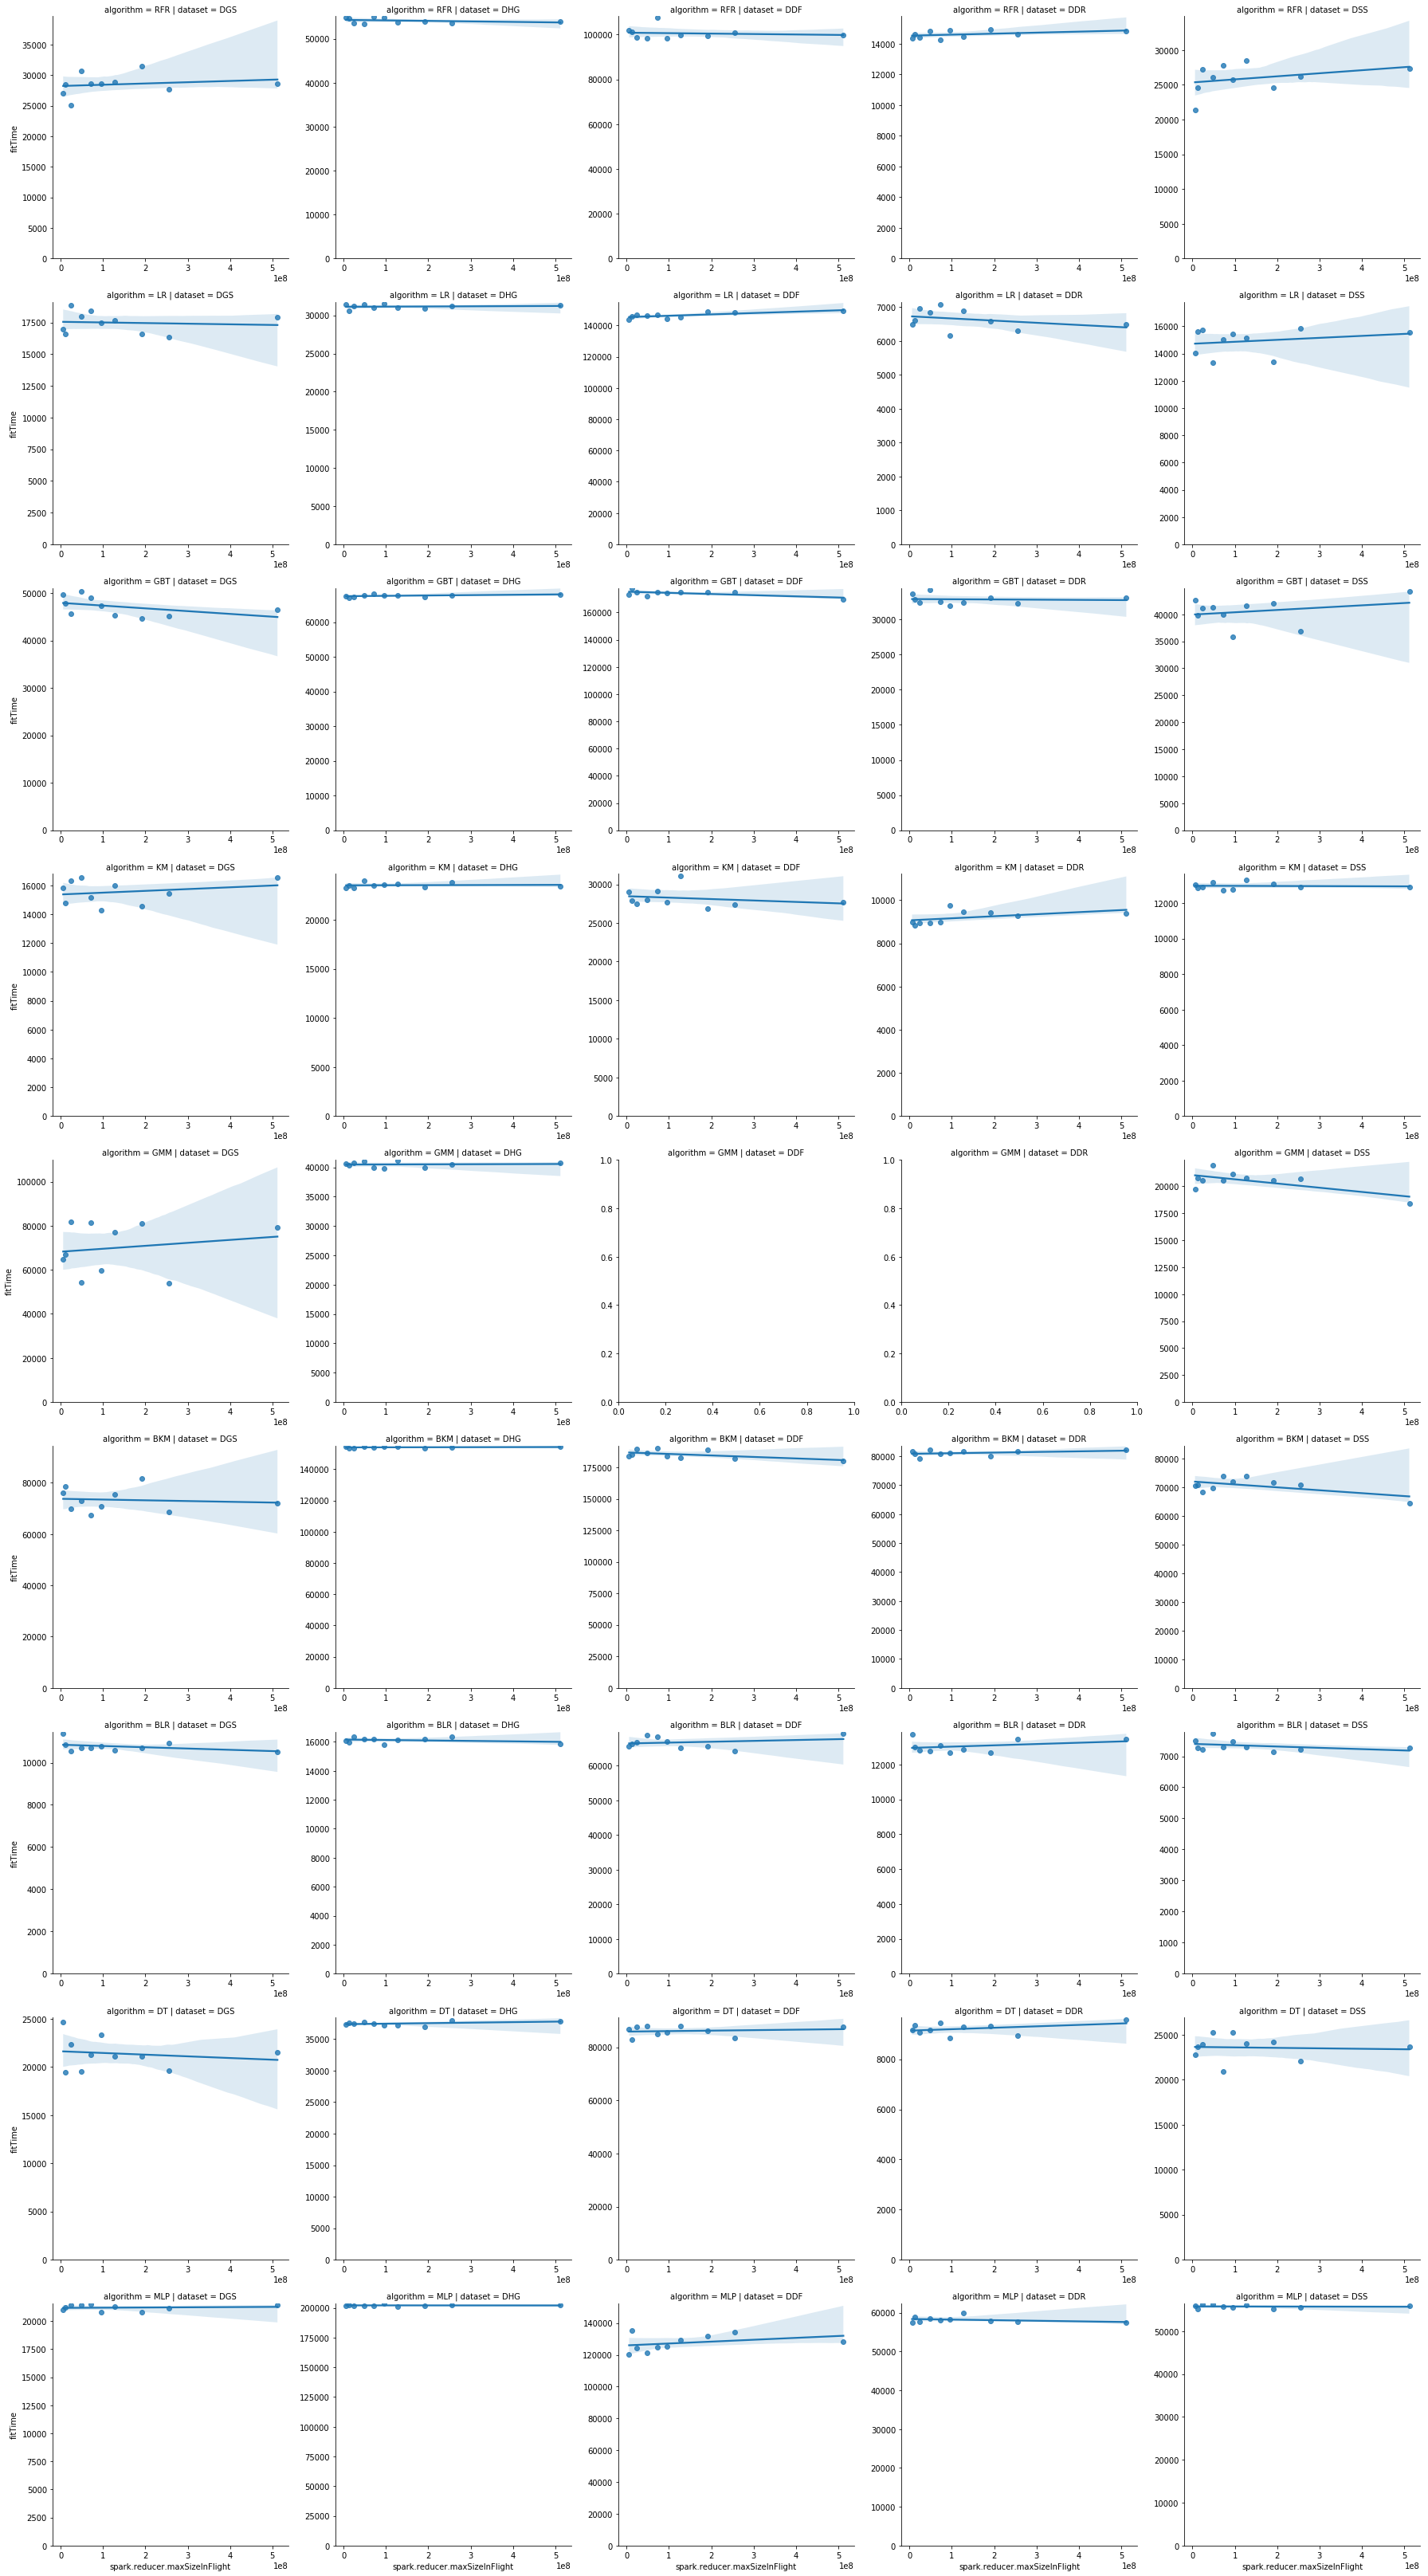

spark.locality.wait


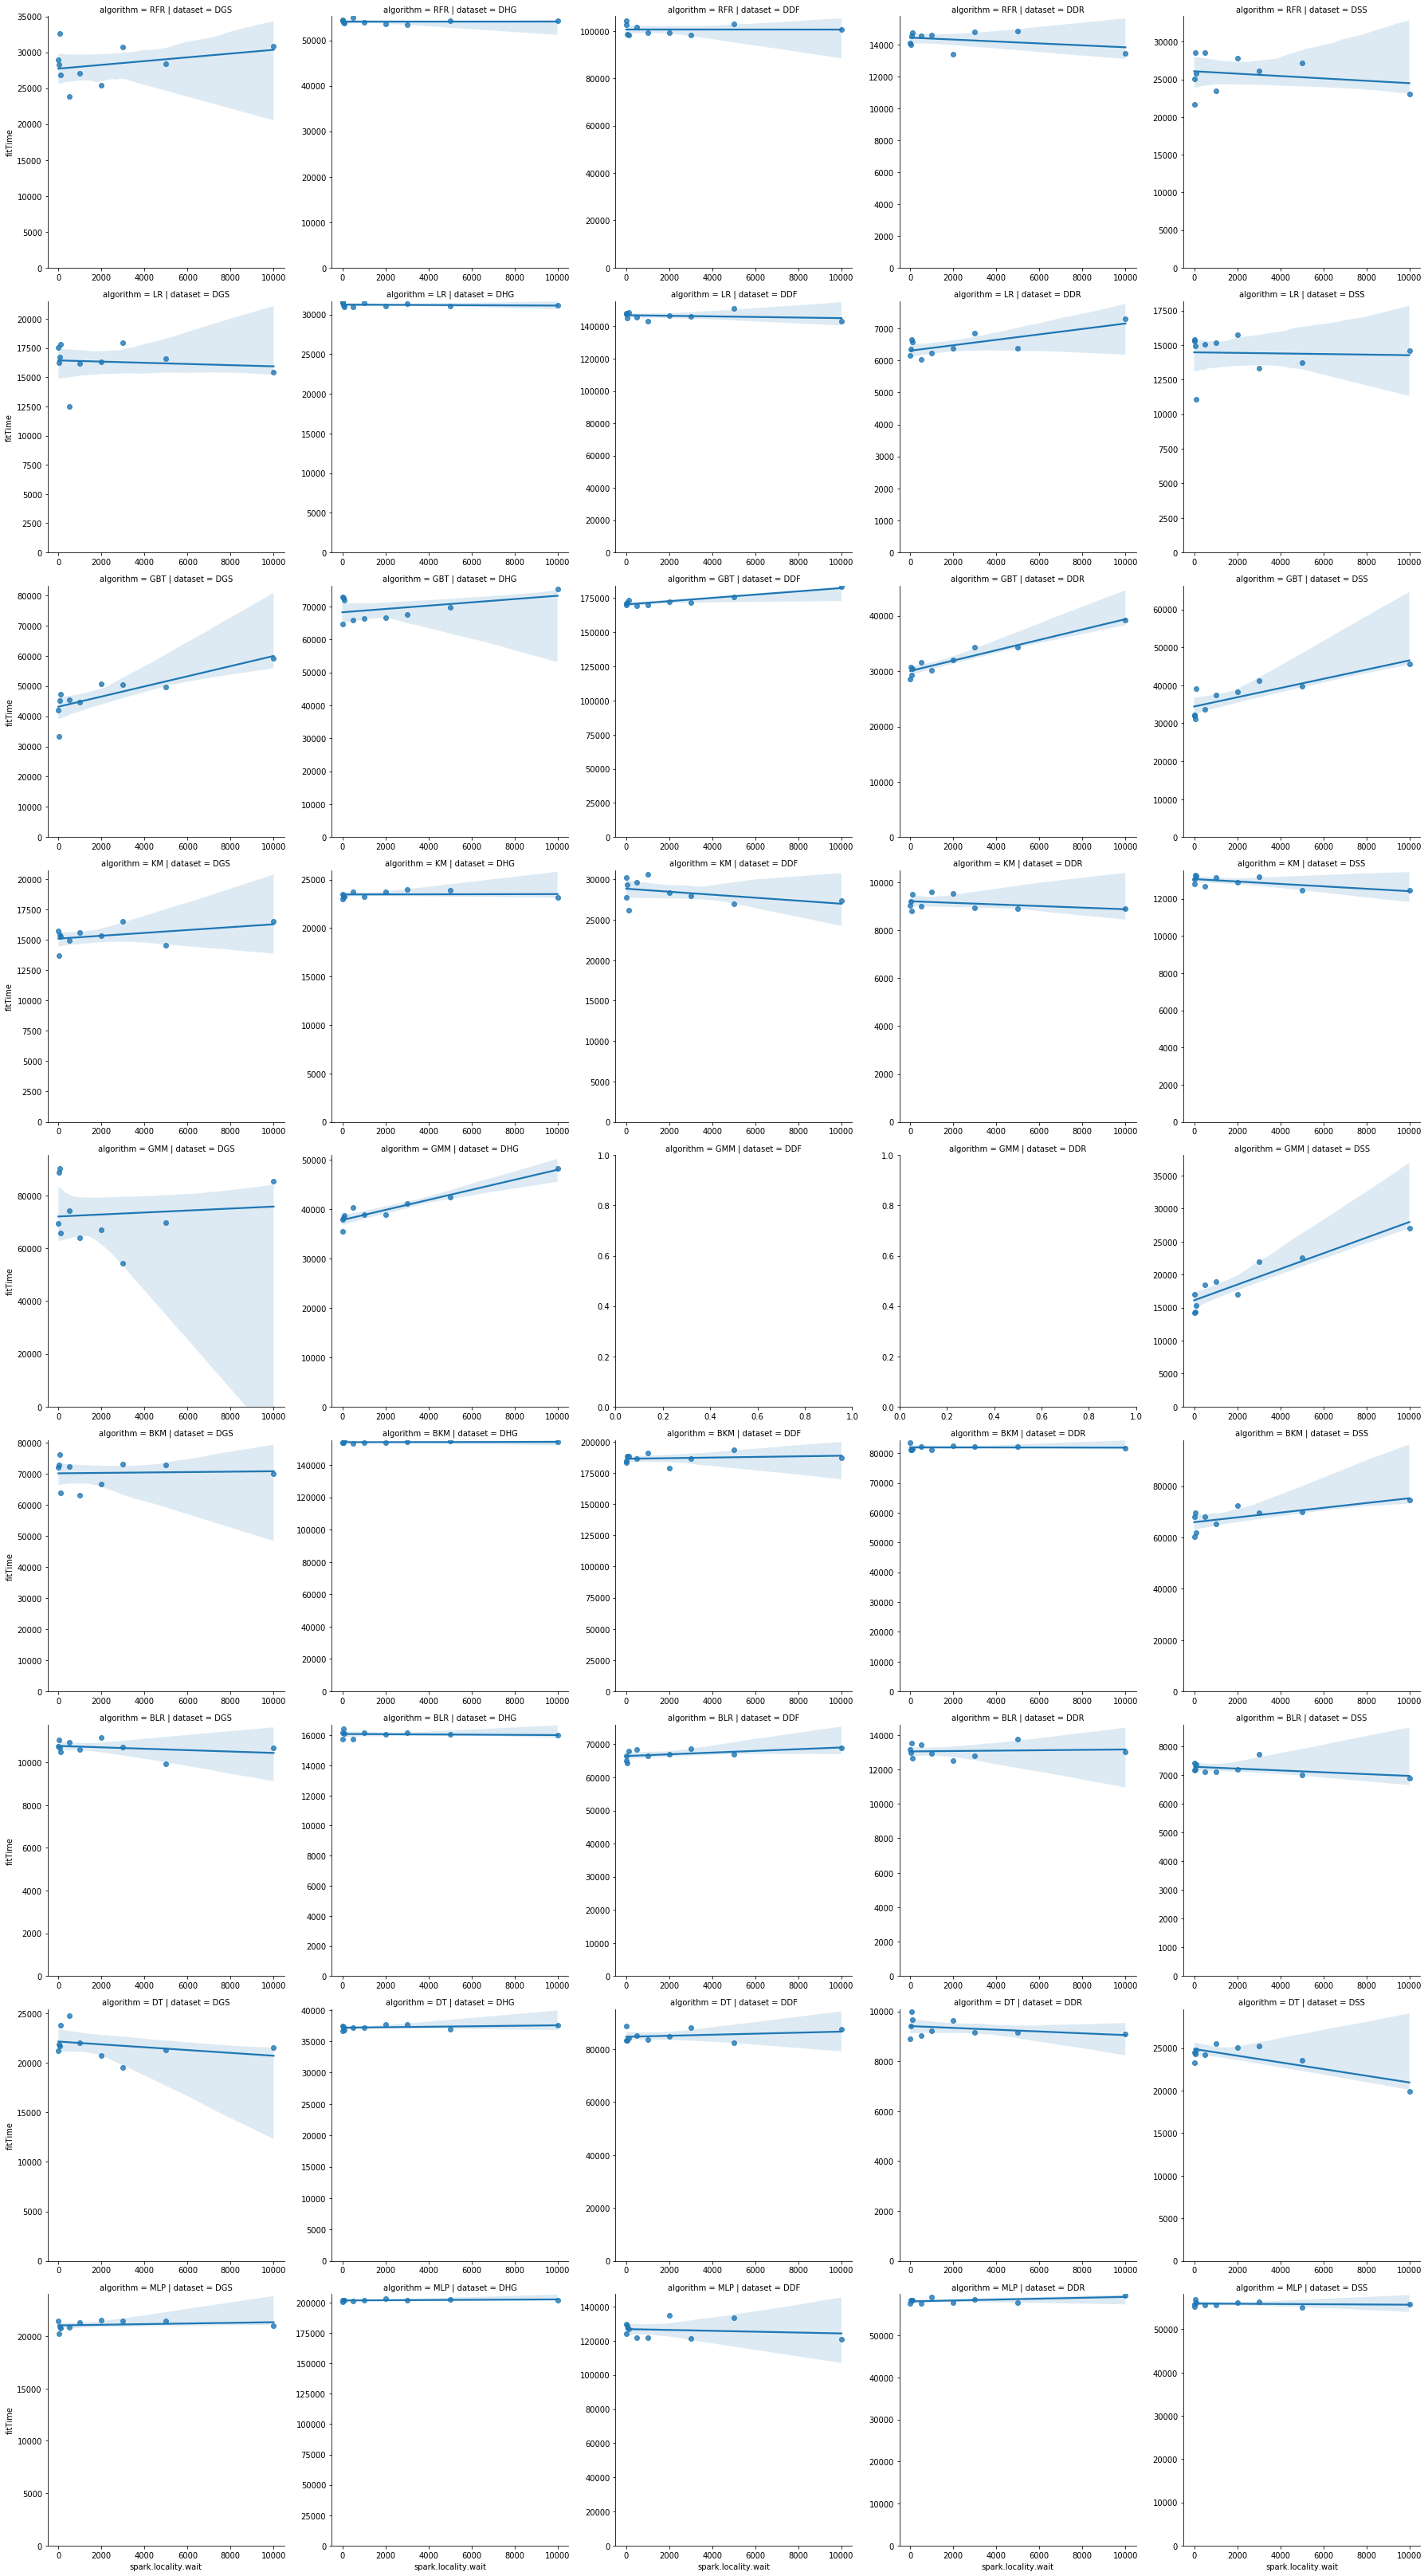

spark.storage.memoryFraction


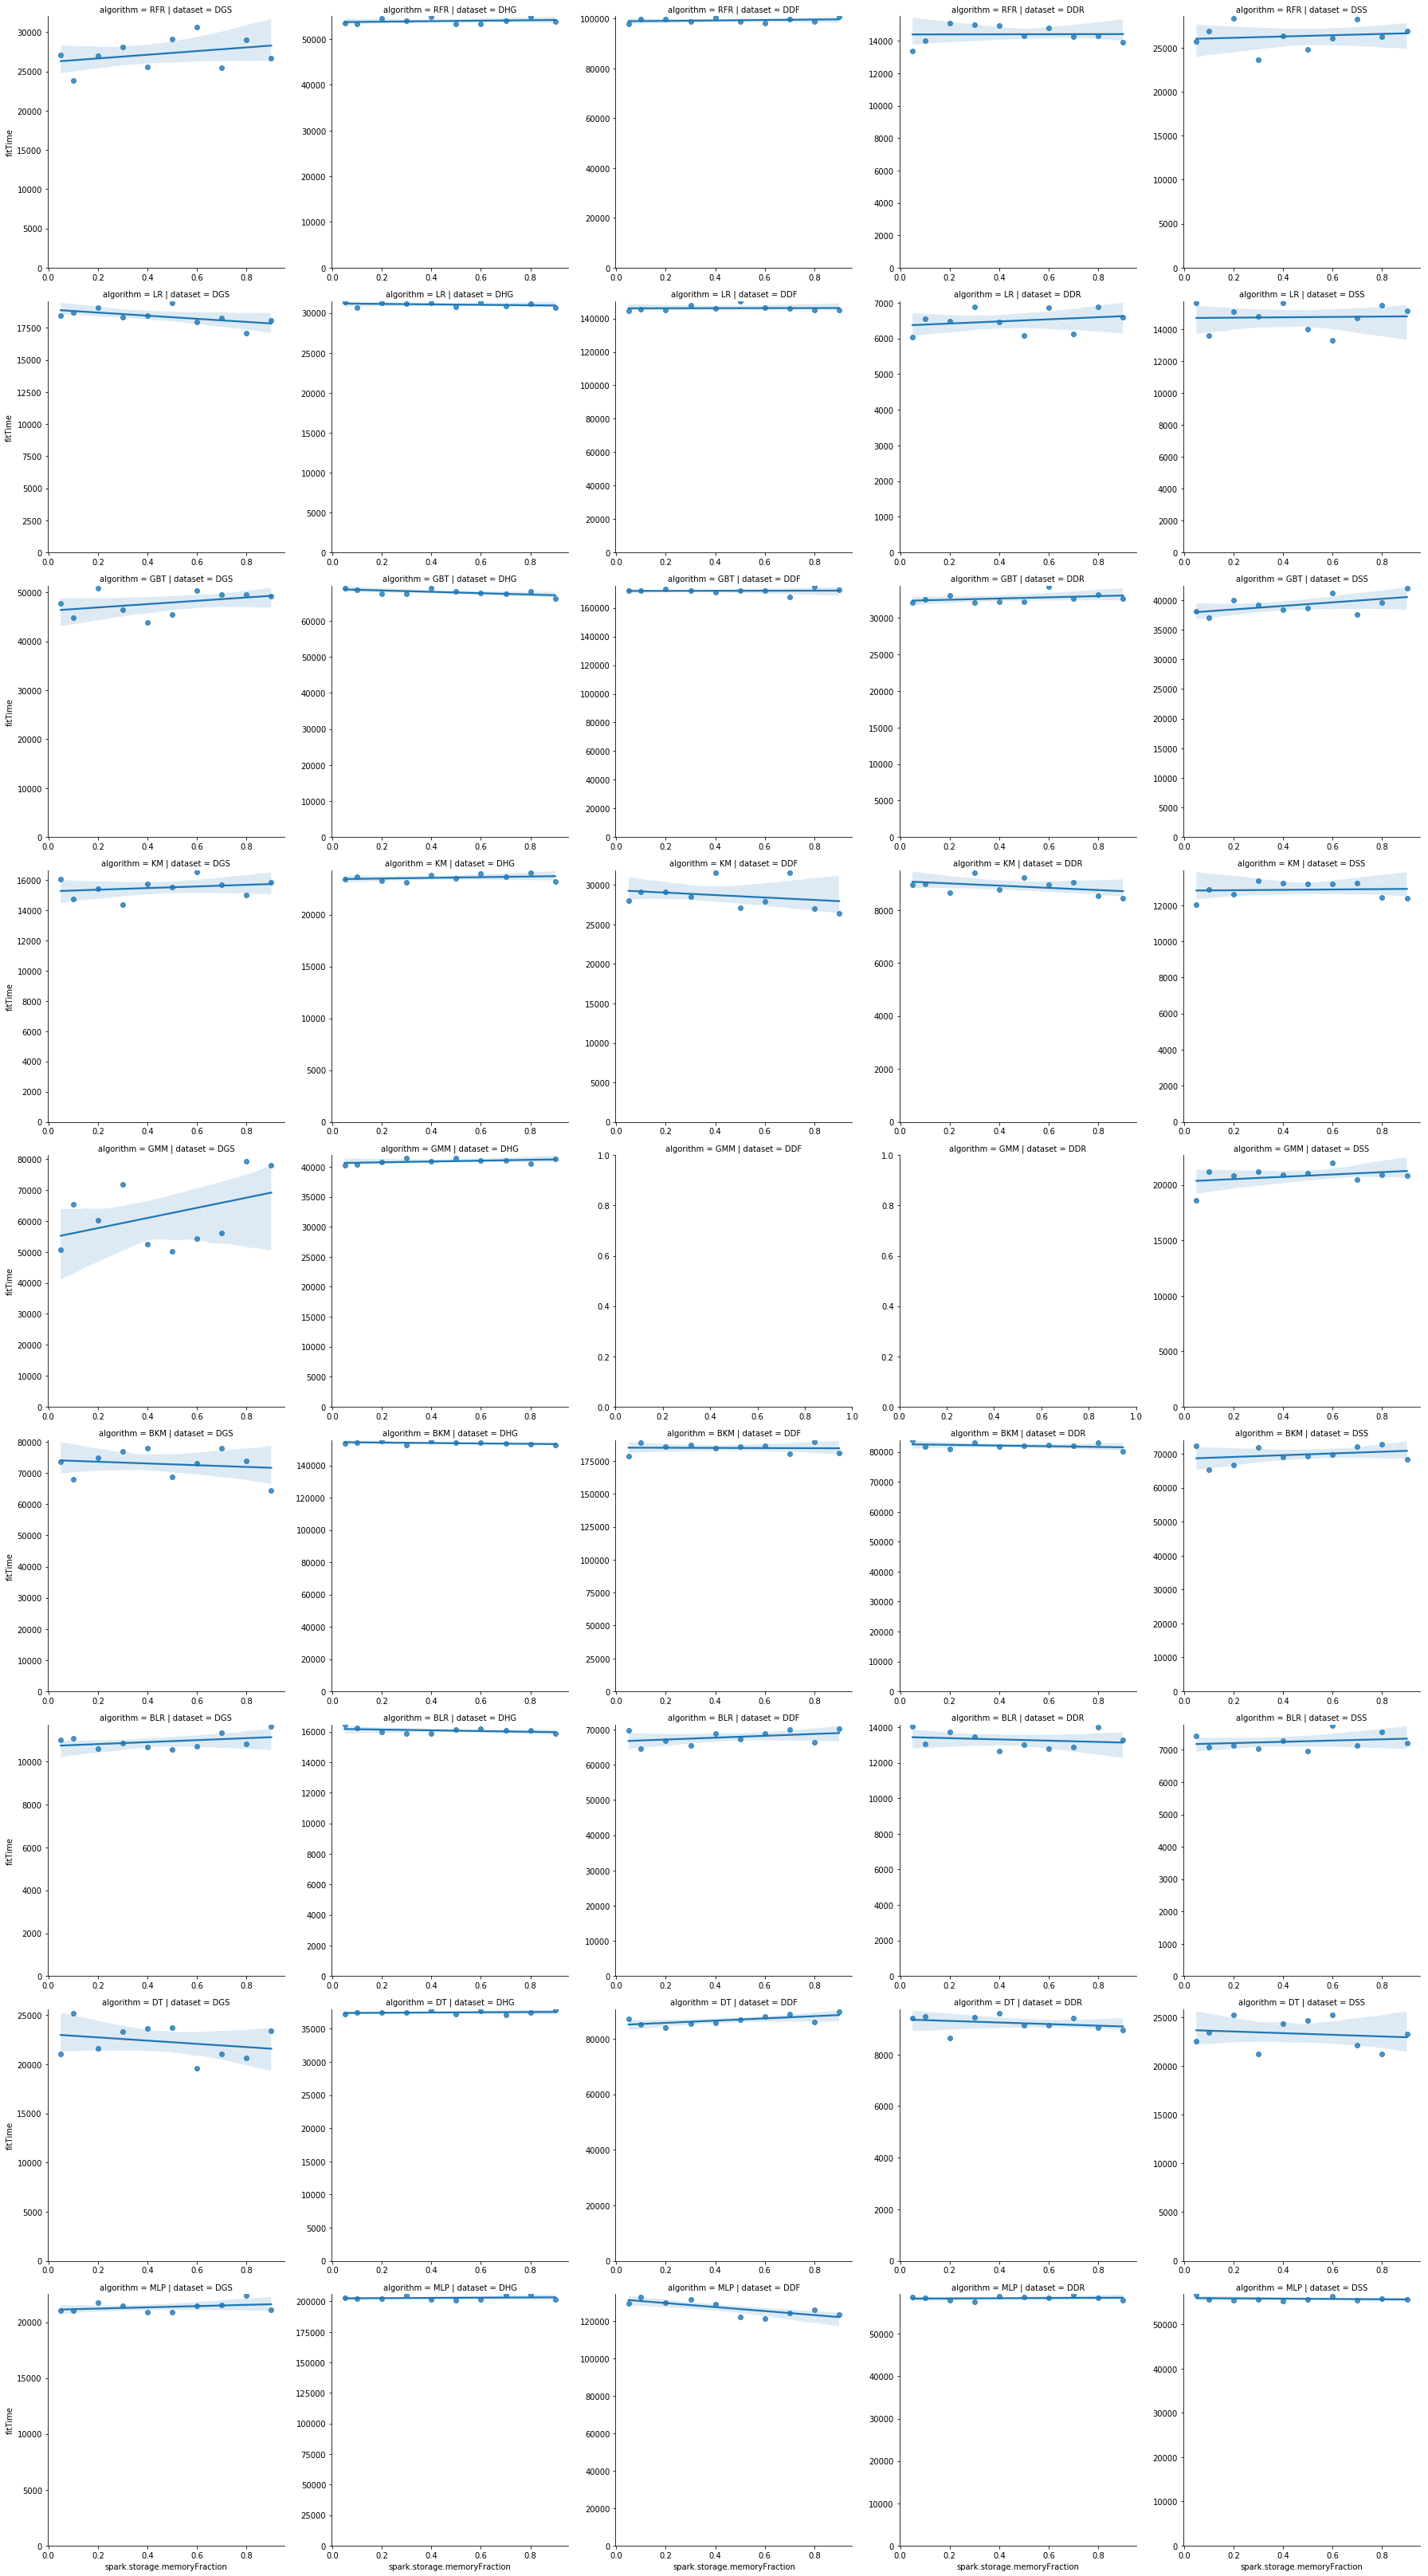

In [18]:
parameters = [
    'spark.executor.cores',
    'spark.executor.memory',
    'spark.shuffle.file.buffer',
    'spark.reducer.maxSizeInFlight',
    'spark.locality.wait',
    'spark.storage.memoryFraction'
]

for parameter in parameters:

    print(parameter)

    plot_workloads_parameter(data, parameter, 'fitTime')
    
    plt.show()